# Exercise 1: Magnetostatics

In [1]:
using LinearAlgebra
using SparseArrays

using Plots
using LaTeXStrings

using gmsh

# Theory
In the first part of this assignment, we will try to model the (quasi)magnetostatic fields of this inductor arrangement in one dimension. The magnetic field is described by
\begin{align*}
    \nabla \times \mathbf{A} & = \mathbf{B} \\
    \nabla \times \mathbf{H} & = \mathbf{J} \\
    \mathbf{B} & = \mu_0 \mu_r \mathbf{H}
\end{align*}
where $\mathbf{A}$ is the magnetic vector potential $\mathrm{[Wb/m]}$, $\mathbf{B}$ is the magnetic flux density $\mathrm{[T]}$, $\mathbf{H}$ is the magnetic field intensity $\mathrm{[A/m]}$, and $\mathbf{J}$ is the (source) current density $\mathrm{[A/m^2]}$. The magnetic flux and field intensity are related by the permeability $\mu = \mu_0 \mu_r$, with $\mu_0 = 4\pi\cdot 10^{-7}$.

## 1D Differential Equation
Since we are modeling this problem in one spatial dimension, the differential equations can be rewritten into a form that is easier to solve, e.g. using the finite difference or finite element methods. We impose that $\mathbf{A} = (0, 0, A_z(x))$ and $\mathbf{J} = (0, 0, J_z(x))$, resulting in
$$ -\nabla \cdot \left[ \frac{1}{\mu} \nabla A_z \right] = J_z \implies -\frac{\partial}{\partial x} \left[ \nu(x) \frac{\partial A_z(x)}{\partial x} \right] = J_z(x) $$
where $\nu(x) = \frac{1}{\mu(x)}$ is the magnetic reluctivity. Note that this equation is very similar to the Laplace/diffusion equations we have been solving until now.

## Variational Form

$$ \frac{\partial}{\partial x} \left[ \nu(x) \frac{\partial A_z(x)}{\partial x} \right] + J_z(x) = 0 \iff \int_\Omega \left[ \frac{\partial}{\partial x} \left[ \nu(x) \frac{\partial A_z(x)}{\partial x} \right] + J_z(x) \right] v_k(x) dx = 0 \qquad 1 \le k \le N $$
We can split the integral into two parts.
$$ -\int_\Omega  \frac{\partial}{\partial x} \left[ \nu(x) \frac{\partial A_z(x)}{\partial x} \right] v_k(x) dx = \int_\Omega J_z(x) v_k(x) dx \qquad 1 \le k \le N $$
It was shown in the lectures that the first integral can be rewritten using integration by parts. Reordering the terms, we obtain the following variational form, consisting of a bilinear term, a linear term, and a boundary contribution.
$$ \int_\Omega \nu(x) \frac{\partial A_z(x)}{\partial x} \frac{\partial v_k(x)}{\partial x} dx = \int_\Omega J_z(x) v_k(x) dx + \left[ \nu(x) \frac{\partial A_z(x)}{\partial x} v_k(x) \right]_{x = x_1}^{x = x_N} \qquad 1 \le k \le N $$
In our treatment of the magnetostatic fields in the inductor configuration, we will impose two homogeneous Dirichlet conditions on the two boundary points $x_1$ and $x_N$. Therefore, the boundary contribution term will become zero.
$$ \int_\Omega \nu(x) \frac{\partial A_z(x)}{\partial x} \frac{\partial v_k(x)}{\partial x} dx = \int_\Omega J_z(x) v_k(x) dx \qquad 1 \le k \le N $$

## Matrix Equations & Implementation
The specific implementation depends on the type of element that is used. In this notebook, we will discuss linear and quadratic elements (P1 and P2). The mass and stiffness matrix contributions are calculated in a separate notebook using ``sympy``. The implementation details will be highlighted in the respective sections.

# Define Geometry
We will first load the previously defined geometry in gmsh and extract the nodes, elements, and physical domains.

In [2]:
gmsh.finalize();
gmsh.initialize();

In [3]:
gmsh.open("geo/coil_geo.msh")

# Retrieve nodes from gmsh and sort in order of x-coords
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
xnode = node_coord[1:3:end];
p = sortperm(xnode);
x = xnode[p];
nids = node_ids[p];

Info    : Reading 'geo/coil_geo.msh'...
Info    : 15 entities
Info    : 114 nodes
Info    : 115 elements
Info    : Done reading 'geo/coil_geo.msh'


In [4]:
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(1)
nelements = length(element_ids[1])

ngroup1 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1)
ngroup2 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)
ngroup3 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 3)
ngroup4 = gmsh.model.mesh.getNodesForPhysicalGroup(1, 4)
e_group = zeros(1,nelements)

for element_id in 1:nelements
    node1_id = element_connectivity[1][2*(element_id-1)+1]
    node2_id = element_connectivity[1][2*(element_id-1)+2]

    G1 = sum(node1_id.== ngroup1[1])+sum(node2_id.== ngroup1[1]) # Air
    G2 = sum(node1_id.== ngroup2[1])+sum(node2_id.== ngroup2[1]) # Core
    G3 = sum(node1_id.== ngroup3[1])+sum(node2_id.== ngroup3[1]) # Coil left
    G4 = sum(node1_id.== ngroup4[1])+sum(node2_id.== ngroup4[1]) # Coil right
    
    if G1 == 2
        e_group[element_id] = 1;
    elseif G2 == 2
        e_group[element_id] = 2;
    elseif G3 == 2
        e_group[element_id] = 3;
    elseif G4 == 2
        e_group[element_id] = 4;
    end
end

# Linear Elements

## Matrix Assembly
We will construct the system of equations using element-wise matrix assembly. This means that we must find the following integrals. The calculation is performed using ``sympy`` in a dedicated notebook.
\begin{align*}
    A_{e_i} & = \int_{e_i} c(x) \begin{bmatrix}
        v_i^\prime v_i^\prime & v_i^\prime v_{i + 1}^\prime \\
        v_i^\prime v_{i + 1}^\prime & v_{i + 1}^\prime v_{i + 1}^\prime \\
    \end{bmatrix} dx = \frac{c(x_i) + c(x_{i+1})}{2 h} \begin{bmatrix}
        1 & -1 \\ -1 & 1
    \end{bmatrix} \\
    f_{e_i} & = \int_{e_i} \begin{bmatrix}
        f(x) v_i(x) \\
        f(x) v_{i+1}(x) \\
    \end{bmatrix} dx = \frac{h}{2} \begin{bmatrix}
        f(x_i) \\ f(x_{i+1})
    \end{bmatrix}
\end{align*}
where $c(x) = \nu(x)$ is the variable diffusion coefficient, and $f(x) = J_z(x)$ is the source function.

## Post-processing
After calculating the potential $A_z(x)$, we are also interested in the magnetic field and other related quantities. The magnetic field can be calculated simply by taking the derivative of $A_z$.
$$ B_y = -\frac{\partial A_z(x)}{\partial x} $$
This derivative is defined _on the elements_, i.e. on the midpoints $x_{i + 0.5}$.

In [8]:
#..Set the source function 
J = 2.2e4;
fsource(group_id) = J * (group_id == 3) - J * (group_id == 4);
fsource_elem = map(fsource, e_group);

mu0 = 4e-7 * pi;
mu_r = 1500;
fmu(group_id) = mu0 + (mu_r - 1) * mu0 * (group_id == 2);
fnu(group_id) = 1 / fmu(group_id);
fnu_elem = map(fnu, e_group);

In [9]:
# Collect points (left and right nodes for each element) and edges (connectivity: indices of left and right nodes)
N = length(x);
points = collect( [x[i], x[i+1]] for i in 1:N-1) 
edges  = collect( [i, i+1] for i in 1:N-1); 

#..Initialize global matrix and right-hand side value 
A = zeros(N, N); 
f = zeros(N); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xr = points[i,:][1]
    h = xr - xl;
    
    floc = h/2 * [1; 1] * fsource_elem[i];
    Aloc = fnu_elem[i] / h * [1 -1; -1 1]; 

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,:]   = zeros(N);  A[1,1]     = 1;      f[1]   = 0;
A[end,:] = zeros(N);  A[end,end] = 1;      f[end] = 0;

#..solve the linear system
u  = A \ f;

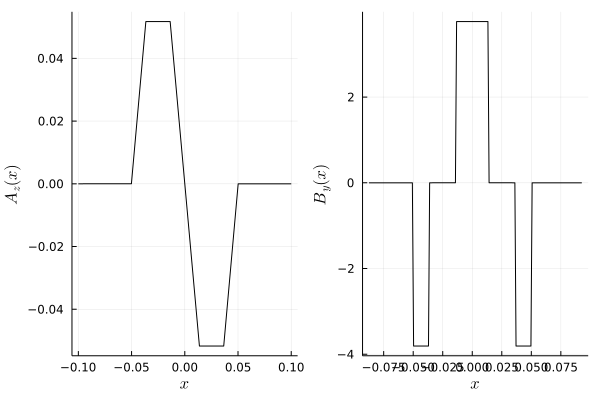

In [10]:
# Post-processing
xmid = diff(x) / 2 + x[1:end-1];
ux = diff(u) ./ diff(x);

# Plot
p1 = plot(x, u, xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(xmid, -ux, xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false);

plot(p1, p2)

# Quadratic Elements

## Modifications to the Nodes
Using quadratic elements, we will consider not only the start and end-point of each element, but also its midpoints. Therefore, we must insert additional nodes at the midpoint of each element for the construction of the matrix. This also means that the matrix size will increase (from $N$ to $2N - 1$, where $N$ is the number of mesh nodes).

## Matrix Assembly
We will construct the system of equations using element-wise matrix assembly. This means that we must find the following integrals. The calculation is performed using ``sympy`` in a dedicated notebook.
\begin{align*}
    A_{e_i} & = \frac{c(e_i) }{3 h} \begin{bmatrix}
         7 & -8 &  1 \\
        -8 & 16 & -8 \\
         1 & -8 &  7 \\
    \end{bmatrix} \\
    f_{e_i} & = \frac{f(e_i) h}{6} \begin{bmatrix}
        1 \\ 4 \\ 1
    \end{bmatrix}
\end{align*}
where $c(x) = \nu(x)$ is the variable diffusion coefficient, and $f(x) = J_z(x)$ is the source function.

## Post-processing
One of the big advantages of using quadratic elements is that the first derivative $u^\prime(x)$ is no longer discontinuous, as it was with linear elements. This means that the derivative is no longer constant on each element, but is instead a linear interpolation (similar to linear elements yielding constant derivatives). This does, however, make the post-processing more difficult. The derivative is defined as
$$ u(x) = \sum_{i = 1}^N u_i \phi_i(x) \implies u^\prime(x) = \sum_{i = 1}^N u_i \phi_i^\prime(x) $$
Therefore, on each element $e_i$, the derivative can be written in terms of the local nodes $i = 1,2,3$.
$$ \left. u^\prime(x) \right|_{e_i} = u_1 \phi_1^\prime(x) + u_2 \phi_2^\prime(x) + u_3 \phi_3^\prime(x)$$
The shape functions and their derivatives, normalized to a $[0, 1]$ reference element, are
\begin{alignat*}{3}
    \phi_1(x) & = 2 x^2 - 3x + 1 \qquad && \phi_1^\prime(x) =  4 x - 3 \\
    \phi_2(x) & = -4 x^2 + 4x \qquad && \phi_2^\prime(x) = -8 x + 4 \\
    \phi_3(x) & = 2 x^2 - x \qquad && \phi_3^\prime(x) =  4 x - 1 \\
\end{alignat*}

In [9]:
Na = 2 * length(x) - 1;
points = collect( [x[i], 0.5*(x[i] + x[i+1]), x[i+1]] for i in 1:length(x)-1) 
edges = collect( [i, i+1, i+2] for i in 1:2:Na-1); 

X = collect([points[i][1], points[i][2]] for i in 1:length(points))
X = reduce(vcat, X);
X = vcat(X, x[end]);

In [10]:
#..Initialize global matrix and right-hand side value 
A = zeros(Na, Na); 
f = zeros(Na); 

#..Perform loop over elements and assemble global matrix and vector 
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    h = xr - xl;
    
    floc = h/6 * [1; 4; 1] * fsource_elem[i];
    Aloc = fnu_elem[i] * [7 -8 1; -8 16 -8; 1 -8 7] / (3 * h); 

    f[edges[i]] += floc;
    A[edges[i], edges[i]] += Aloc;
end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,:]   = zeros(Na);  A[1,1]     = 1;      f[1]   = 0;
A[end,:] = zeros(Na);  A[end,end] = 1;      f[end] = 0;

#..solve the linear system
u  = A \ f;

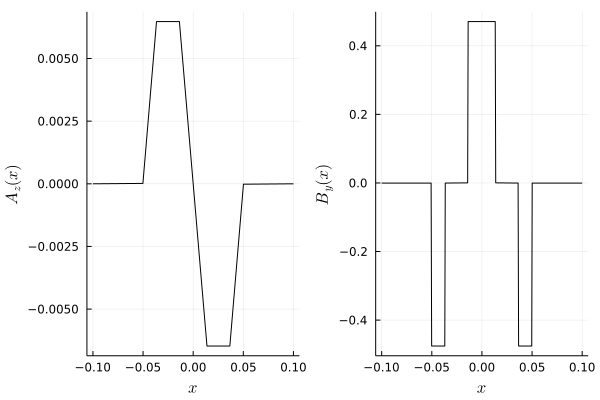

In [11]:
# Post-processing
ux = zeros(Na);

Emat = [4, -8, 4] * [0 0.5 1] .+ [-3, 4, -1];
for i=1:length(edges) 
    xl, xm, xr = points[i,:][1];
    ul, um, ur = u[edges[i]];
    
    dux = [ul um ur] * Emat / (xr - xl);
    
    ux[edges[i]] = dux';
end

# Plot
p1 = plot(X, u, xlabel = L"x", ylabel = L"A_z(x)", color = :black, lw = 1, legend = false);
p2 = plot(X, -ux, xlabel = L"x", ylabel = L"B_y(x)", color = :black, lw = 1, legend = false);

plot(p1, p2)